# Section 3: Data Visualization

The human brain excels at finding patterns in visual representations of the data; so in this section, we will learn how to visualize data using `pandas` along with the `matplotlib` and `seaborn` libraries for additional features. We will create a variety of visualizations that will help us better understand our data.

## Plotting with pandas

We can create a variety of visualizations using the `plot()` method. In this section, we will take a brief tour of some of this functionality, which under the hood uses `matplotlib`.

Once again, we will be working with the TSA traveler throughput data that we cleaned up in the previous section:

In [1]:
import pandas as pd

tsa_melted_holiday_travel = pd.read_csv(
    '../data/tsa_melted_holiday_travel.csv', 
    parse_dates=True, index_col='date'
)
tsa_melted_holiday_travel.head()

,year,travelers,holiday
date,,,
2019-01-01,2019,2126398.0,New Year's Day
2019-01-02,2019,2345103.0,New Year's Day
2019-01-03,2019,2202111.0,NaN
2019-01-04,2019,2150571.0,NaN
2019-01-05,2019,1975947.0,NaN


To embed our plots in the notebook, we will also call the `%matplotlib inline` magic:

In [2]:
%matplotlib inline

### Line plots

The `plot()` method will generate line plots for all numeric columns by default:

<AxesSubplot:title={'center':'2020 TSA Traveler Throughput'}, xlabel='date', ylabel='travelers'>

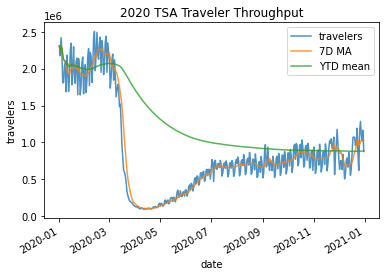

In [3]:
tsa_melted_holiday_travel.drop(columns='year').loc['2020'].assign(
    **{
        '7D MA': lambda x: x.travelers.rolling('7D').mean(),
        'YTD mean': lambda x: x.travelers.expanding().mean()
      }
).plot(
    title='2020 TSA Traveler Throughput', 
    ylabel='travelers', alpha=0.8
)

*Tip: This method returned an `Axes` object that can be modified further (e.g. to add reference lines, annotations, labels, etc.).*

### Bar plots

Pandas offers other plot types via the `kind` parameter. Here, we plot vertical bars to compare monthly TSA traveler throughput across years. Then, we further format the visualization using the `Axes` object returned by the `plot()` method:

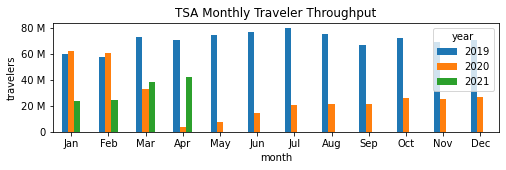

In [4]:
import calendar
from matplotlib import ticker

ax = tsa_melted_holiday_travel['2019':'2021-04'].assign(month=lambda x: x.index.month)\
    .pivot_table(index='month', columns='year', values='travelers', aggfunc='sum')\
    .plot(
        kind='bar', rot=0, figsize=(8, 2), ylabel='travelers',
        title='TSA Monthly Traveler Throughput'
    )

# use month abbreviations for the ticks on the x-axis
ax.set_xticklabels(calendar.month_abbr[1:])

# show y-axis labels in millions instead of scientific notation
ax.yaxis.set_major_formatter(ticker.EngFormatter())

Some additional things to keep in mind:
- Matplotlib's `ticker` module provides functionality for customizing both the tick labels and locations &ndash; check out the [documentation](https://matplotlib.org/stable/api/ticker_api.html) for more information.
- Pandas supports horizontal and stacked bars as well; [this](https://opendatascience.com/how-to-pivot-and-plot-data-with-pandas/) blog post shows how to make stacked horizontal bars using a pivot table.
- The `plot()` method takes a lot of [parameters](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html), many of which get passed down to `matplotlib`; however, sometimes we need to use `matplotlib` calls directly.

### Plotting distributions

Pandas has generated the `Figure` and `Axes` objects for both examples so far, but we can build custom layouts by creating them ourselves with `matplotlib` using the `plt.subplots()` function. First, we will need to import the `pyplot` module:

In [5]:
import matplotlib.pyplot as plt

Let's compare the distribution of daily TSA traveler throughput across years:

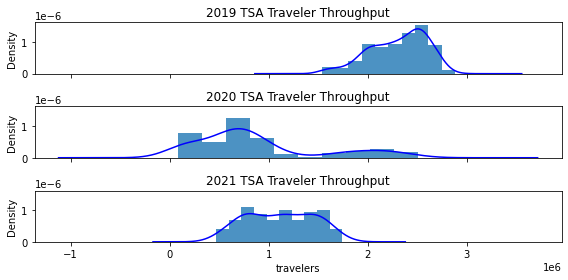

In [6]:
# define the subplot layout
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 4))

for year, ax in zip(tsa_melted_holiday_travel.year.unique(), axes):
    plot_data = tsa_melted_holiday_travel.loc[str(year)].travelers
    plot_data.plot(kind='hist', legend=False, density=True, alpha=0.8, ax=ax)
    plot_data.plot(kind='kde', legend=False, color='blue', ax=ax)
    ax.set(title=f'{year} TSA Traveler Throughput', xlabel='travelers')

plt.tight_layout() # handle overlaps

*Tip: While `pandas` lets us specify that we want subplots and their layout (with the `subplots` and `layout` parameters, respectively), this gives us additional flexibility.*

## Plotting with seaborn

The `seaborn` library provides the means to easily visualize long-format data without first pivoting it. In addition, it also offers some additional plot types &ndash; once again building on top of `matplotlib`. Here, we will look at a few examples of visualizations we can create with `seaborn`.

### Visualizing long-format data

With `seaborn`, we can specify plot colors according to values of a column with the `hue` parameter. When working with functions that generate subplots, we can also specify how to split the subplots by values of a long-format column with the `col` and `row` parameters. Here, we revisit the comparison of the distribution of TSA traveler throughput across years:

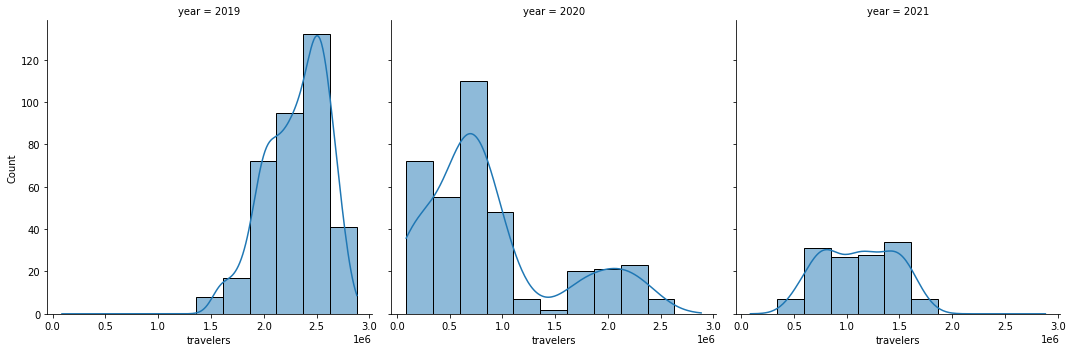

In [7]:
import seaborn as sns

sns.displot(data=tsa_melted_holiday_travel, x='travelers', kde=True, col='year')

### Heatmaps
We can use `seaborn` to visualize pivot tables as heatmaps:

Text(0.5, 1.0, 'Total TSA Traveler Throughput (in millions)')

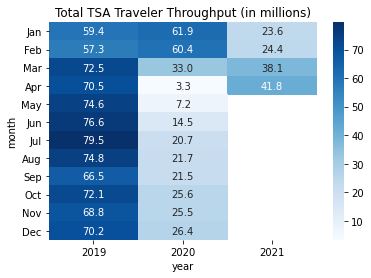

In [8]:
data = tsa_melted_holiday_travel['2019':'2021-04'].assign(month=lambda x: x.index.month)\
    .pivot_table(index='month', columns='year', values='travelers', aggfunc='sum')

ax = sns.heatmap(data=data / 1e6, cmap='Blues', annot=True, fmt='.1f')
ax.set_yticklabels(calendar.month_abbr[1:], rotation=0)
ax.set_title('Total TSA Traveler Throughput (in millions)')

We're moving on from `seaborn` now, but there is a lot more available in the [API](https://seaborn.pydata.org/api.html). Be sure to check out the following at a minimum:
- [pairwise plots](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot) with `pairplot()`
- [categorical scatter plots](https://seaborn.pydata.org/generated/seaborn.swarmplot.html#seaborn.swarmplot) with `swarmplot()`
- [joint distribution plots](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot) with `jointplot()`
- [FacetGrids](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html#seaborn.FacetGrid) for custom layouts with any plot type

## Customizing plots with matplotlib

In this final section, we will discuss how to use `matplotlib` to customize plots. Since there is a lot of functionality available, we will only be covering how to add shaded regions and annotations here, but be sure to check out the [documentation](https://matplotlib.org/) for more.

### Adding shaded regions

When looking at a plot of TSA traveler throughput over time, it's helpful to indicate periods during which there was holiday travel. We can do so with the `plt.axvspan()` function:

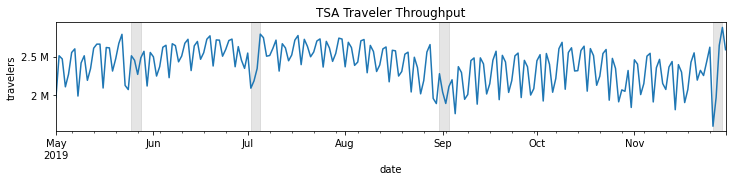

In [9]:
plot_data = tsa_melted_holiday_travel['2019-05':'2019-11']
plot_data.travelers.plot(
    title='TSA Traveler Throughput', ylabel='travelers', figsize=(12, 2)
).yaxis.set_major_formatter(ticker.EngFormatter())

# collect the holiday ranges (start and end dates)
holiday_ranges = plot_data.dropna().reset_index()\
    .groupby('holiday').agg({'date': ['min', 'max']})

# create shaded regions for each holiday in the plot
for start_date, end_date in holiday_ranges.to_numpy():
    plt.axvspan(start_date, end_date, color='gray', alpha=0.2)

*Tip: Use `plt.axhspan()` for horizontally shaded regions and `plt.axvline()` / `plt.axhline()` for vertical/horizontal reference lines.*

### Adding annotations

We can use the `plt.annotate()` function to add annotations to the plot. Here, we point out the day in 2019 with the highest TSA traveler throughput, which was the day after Thanksgiving:

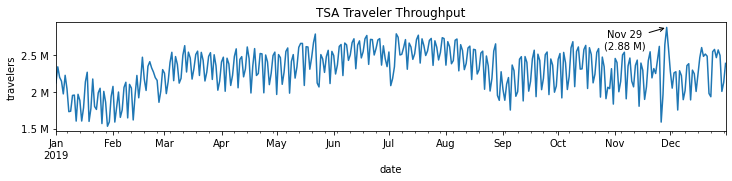

In [10]:
plot_data = tsa_melted_holiday_travel.loc['2019']
plot_data.travelers.plot(
    title='TSA Traveler Throughput', ylabel='travelers', figsize=(12, 2)
).yaxis.set_major_formatter(ticker.EngFormatter())

# highest throughput
max_throughput_date = plot_data.travelers.idxmax()
max_throughput = plot_data.travelers.max()
_ = plt.annotate(
    f'{max_throughput_date:%b %d}\n({max_throughput / 1e6:.2f} M)',
    xy=(max_throughput_date, max_throughput),
    xytext=(max_throughput_date - pd.Timedelta(days=23), max_throughput * 0.9),
    arrowprops={'arrowstyle': '->'}, ha='center'
)

Some things to keep in mind: 
- We used `plt` functions to customize our plots, but `Axes` objects have equivalent methods for adding shaded regions, reference lines, annotations, etc. &ndash; although the method names might be slightly different than their `plt` function counterparts (e.g. `Axes.set_xlabel()` vs. `plt.xlabel()`). 
- Likewise, `plt` functions can be used to add plot titles and axis labels, with the important caveat that  `Axes` methods should always be used instead when dealing with subplots &ndash; otherwise, the action will only affect the last subplot.

## Up Next: Hands-On Data Analysis Lab

Let's take a 15-minute break for some exercises to check your understanding:

1. Create box plots of TSA traveler throughput for each year in the data. Hint: Pass `kind='box'` into the `plot()` method to generate box plots.
2. Using `seaborn`, create a heatmap that shows the 2019 TSA median traveler throughput by day of week and month. Hint: Make a pivot table first.
3. Annotate the medians in the box plot from *#1*. Hint: The `x` coordinates will be 1, 2, and 3 for 2019, 2020, and 2021, respectively. Alternatively, to avoid hardcoding values, you can use the `Axes.get_xticklabels()` method, in which case you should look at the [documentation](https://matplotlib.org/stable/api/text_api.html) for the `Text` class.

### Exercises

##### 1. Create box plots of TSA traveler throughput for each year in the data. Hint: Pass `kind='box'` into the `plot()` method to generate box plots.

##### 2. Using `seaborn`, create a heatmap that shows the 2019 TSA median traveler throughput by day of week and month.

##### 3. Annotate the medians in the box plot from *#1*. Hint: The `x` coordinates will be 1, 2, and 3 for 2019, 2020, and 2021, respectively. Alternatively, to avoid hardcoding values, you can use the `Axes.get_xticklabels()` method, in which case you should look at the [documentation](https://matplotlib.org/stable/api/text_api.html) for the `Text` class.